# 日志刷屏使我痛苦，我开发了VLog😋

训练日志刷屏使我痛苦，我开发了VLog，可以在任意训练代码中轻松使用~

例如，通过回调嵌入到lightgbm/catboost/transformers/ultralytics，乃至keras库的训练代码流程中~


**before**:

![](./data/before.png)



**after**：

![](./data/torchkeras_plot.gif)


**为什么不用tensorboard或者wandb?**

tensorboard需要开端口权限，服务器开发环境有时候没有端口权限~

wandb需要联网，有时候网速很差或者没有网，影响体验~

综合对比考虑如下表

|日志方案    | 学习成本|  指标直观性 |是否需要端口权限|是否需要联网 |推荐星级|
|:---------|:------:|:-------------:|:---------:|:---------:|:-----|
|print      | 无需学习 |不直观,易刷屏|不需要    |不需要     |⭐️|
|tensorboard| 较难学习 |比较直观,跨页面      |需要       |不需要     |⭐️⭐️|
|wandb      | 较好学习 |比较直观,跨页面      |不需要     |需要       |⭐️⭐️⭐️⭐️|
|VLog😋     | 极易学习 |非常直观,同页面      |不需要     |不需要      |⭐️⭐️⭐️⭐️⭐️|



In [ ]:
#!pip install -U lightgbm 
#!pip install ultralytics
#!pip install git+https://github.com/lyhue1991/torchkeras 

## 一，VLog基本原理

VLog类主要有以下5个方法。

```python

from torchkeras import VLog

#1, 初始化方法
vlog = VLog(epochs=20, monitor_metric='val_loss', monitor_mode='min') 

#2, 显示开始空图表
vlog.log_start()

#3, 更新step级别日志
vlog.log_step({'train_loss':0.003,'val_loss':0.002}) 

#4, 更新epoch级别日志
vlog.log_epoch({'train_acc':0.9,'val_acc':0.87,'train_loss':0.002,'val_loss':0.03})

#5, 输出最终稳定状态图表
vlog.log_end()
```


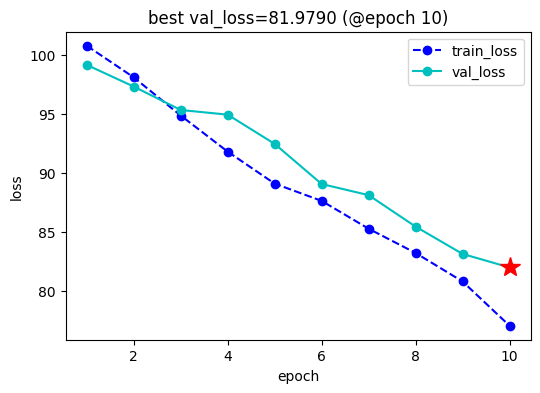

,val_loss,train_loss,epoch
0,99.175805,100.803715,1
1,97.334170,98.115262,2
2,95.346233,94.875238,3
3,94.949246,91.809134,4
4,92.467559,89.092992,5
5,89.060268,87.629074,6
6,88.117432,85.265212,7
7,85.445769,83.205913,8
8,83.124590,80.787413,9
9,81.979003,77.028675,10


In [2]:
import time
import math,random
from torchkeras import VLog

epochs = 10
batchs = 30

#0, 指定监控北极星指标，以及指标优化方向
vlog = VLog(epochs, monitor_metric='val_loss', monitor_mode='min') 

#1, log_start 初始化动态图表
vlog.log_start() 

for epoch in range(epochs):
    
    #train
    for step in range(batchs):
        
        #2, log_step 更新step级别日志信息，打日志，并用小进度条显示进度
        vlog.log_step({'train_loss':100-2.5*epoch+math.sin(2*step/batchs)}) 
        time.sleep(0.05)
        
    #eval    
    for step in range(20):
        
        #3, log_step 更新step级别日志信息，指定training=False说明在验证模式，只打日志不更新小进度条
        vlog.log_step({'val_loss':100-2*epoch+math.sin(2*step/batchs)},training=False)
        time.sleep(0.05)
        
    #4, log_epoch 更新epoch级别日志信息，每个epoch刷新一次动态图表和大进度条进度
    vlog.log_epoch({'val_loss':100 - 2*epoch+2*random.random()-1,
                    'train_loss':100-2.5*epoch+2*random.random()-1})  

# 5, log_end 调整坐标轴范围，输出最终指标可视化图表
vlog.log_end()


## 二，在LightGBM中使用VLog 

设计一个简单的回调，就可以搞定~

In [ ]:
from torchkeras import VLog
class VLogCallback:
    def __init__(self, num_boost_round, 
                 monitor_metric='val_loss',
                 monitor_mode='min'):
        self.order = 20
        self.num_boost_round = num_boost_round
        self.vlog = VLog(epochs = num_boost_round, monitor_metric = monitor_metric, 
                         monitor_mode = monitor_mode)

    def __call__(self, env) -> None:
        metrics = {}
        for item in env.evaluation_result_list:
            if len(item) == 4:
                data_name, eval_name, result = item[:3]
                metrics[data_name+'_'+eval_name] = result
            else:
                data_name, eval_name = item[1].split()
                res_mean = item[2]
                res_stdv = item[4]
                metrics[data_name+'_'+eval_name] = res_mean
        self.vlog.log_epoch(metrics)
        

In [ ]:
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(info+'...\n\n')

#================================================================================
# 一，读取数据
#================================================================================
printlog("step1: reading data...")

# 读取dftrain,dftest
breast = datasets.load_breast_cancer()
df = pd.DataFrame(breast.data,columns = [x.replace(' ','_') for x in breast.feature_names])
df['label'] = breast.target
df['mean_radius'] = df['mean_radius'].apply(lambda x:int(x))
df['mean_texture'] = df['mean_texture'].apply(lambda x:int(x))
dftrain,dftest = train_test_split(df)

categorical_features = ['mean_radius','mean_texture']
lgb_train = lgb.Dataset(dftrain.drop(['label'],axis = 1),label=dftrain['label'],
                        categorical_feature = categorical_features)

lgb_valid = lgb.Dataset(dftest.drop(['label'],axis = 1),label=dftest['label'],
                        categorical_feature = categorical_features,
                        reference=lgb_train)

#================================================================================
# 二，设置参数
#================================================================================
printlog("step2: setting parameters...")
                               
boost_round = 50                   
early_stop_rounds = 10

params = {
    'boosting_type': 'gbdt',
    'objective':'binary',
    'metric': ['auc'], #'l2'
    'num_leaves': 15,   
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'early_stopping_round':5
}

#================================================================================
# 三，训练模型
#================================================================================
printlog("step3: training model...")

result = {}

vlog_cb = VLogCallback(boost_round, monitor_metric = 'val_auc', monitor_mode = 'max')
vlog_cb.vlog.log_start()

gbm = lgb.train(params,
                lgb_train,
                num_boost_round= boost_round,
                valid_sets=(lgb_valid, lgb_train),
                valid_names=('val','train'),
                callbacks = [lgb.record_evaluation(result),
                             vlog_cb]
               )

vlog_cb.vlog.log_end()

#================================================================================
# 四，评估模型
#================================================================================
printlog("step4: evaluating model ...")

y_pred_train = gbm.predict(dftrain.drop('label',axis = 1), num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(dftest.drop('label',axis = 1), num_iteration=gbm.best_iteration)

print('train accuracy: {:.5} '.format(accuracy_score(dftrain['label'],y_pred_train>0.5)))
print('valid accuracy: {:.5} \n'.format(accuracy_score(dftest['label'],y_pred_test>0.5)))


#================================================================================
# 五，保存模型
#================================================================================
printlog("step5: saving model ...")


model_dir = "gbm.model"
print("model_dir: %s"%model_dir)
gbm.save_model("gbm.model")
printlog("task end...")

###
##
#

## 三， 在ultralytics中使用VLog

写个适配的回调~

ultralytics可以做 分类，检测，分割 等等。

这个回调函数是通用的，此处以分类问题为例，改个monitor_metric即可~


cats_vs_dogs数据集可以在公众号算法美食屋后台回复:**torchkeras** 获取~ 


In [ ]:
from torchkeras import VLog
class VLogCallback:
    def __init__(self,epochs,monitor_metric,monitor_mode):
        self.vlog = VLog(epochs,monitor_metric,monitor_mode)
        
    def on_train_batch_end(self,trainer):
        self.vlog.log_step(trainer.label_loss_items(trainer.tloss, prefix='train'))

    def on_fit_epoch_end(self,trainer):
        metrics = {k.split('/')[-1]:v for k,v in trainer.metrics.items() if 'loss' not in k}
        self.vlog.log_epoch(metrics)

    def on_train_epoch_end(self,trainer):
        pass

In [ ]:
from ultralytics import YOLO 
epochs = 10

vlog_cb = VLogCallback(epochs = epochs,
                       monitor_metric='accuracy_top1',
                       monitor_mode='max')
callbacks = {
    "on_train_batch_end": vlog_cb.on_train_batch_end,
    "on_fit_epoch_end": vlog_cb.on_fit_epoch_end
}

model = YOLO(model = 'yolov8n-cls.pt')
for event,func in callbacks.items():
    model.add_callback(event,func)
    
vlog_cb.vlog.log_start()
results = model.train(data='cats_vs_dogs', 
                      epochs=epochs, workers=4)     # train the model
vlog_cb.vlog.log_end()


## 四， 在transformers中使用VLog 

waimai评论数据集可以在公众号算法美食屋后台回复:**torchkeras** 获取~ 

In [ ]:
#回调给你写好了~
from torchkeras.tools.transformers import VLogCallback 

In [ ]:
import numpy as np 
import pandas as pd 
import torch 
import datasets 
from transformers import AutoTokenizer,DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification 
from transformers import TrainingArguments,Trainer 
from transformers import EarlyStoppingCallback

from tqdm import tqdm 
from transformers import AdamW, get_scheduler


#一，准备数据

df = pd.read_csv("waimai_10k.csv")
ds = datasets.Dataset.from_pandas(df)
ds = ds.shuffle(42) 
ds = ds.rename_columns({"review":"text","label":"labels"})

tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese') 

ds_encoded = ds.map(lambda example:tokenizer(example["text"]),
                    remove_columns = ["text"],
                    batched=True)

#train,val,test split
ds_train_val,ds_test = ds_encoded.train_test_split(test_size=0.2).values()
ds_train,ds_val = ds_train_val.train_test_split(test_size=0.2).values() 

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, collate_fn = data_collator)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=16,  collate_fn = data_collator)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=16,  collate_fn = data_collator)

for batch in dl_train:
    break
print({k: v.shape for k, v in batch.items()})



#二，定义模型
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-chinese',num_labels=2)

#三，训练模型
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)
    accuracy = np.sum(preds==labels)/len(labels)
    precision = np.sum((preds==1)&(labels==1))/np.sum(preds==1)
    recall = np.sum((preds==1)&(labels==1))/np.sum(labels==1)
    f1  = 2*recall*precision/(recall+precision)
    return {"accuracy":accuracy,"precision":precision,"recall":recall,'f1':f1}

training_args = TrainingArguments(
    output_dir = "bert_waimai",
    num_train_epochs = 3,
    logging_steps = 20,
    gradient_accumulation_steps = 10,
    evaluation_strategy="steps", #epoch
    
    metric_for_best_model='eval_f1',
    greater_is_better=True,
    
    report_to='none',
    load_best_model_at_end=True
)

callbacks = [EarlyStoppingCallback(early_stopping_patience=10),
             VLogCallback()] #监控指标同 metric_for_best_model

trainer = Trainer(
    model,
    training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    callbacks = callbacks,
    data_collator=data_collator,
    tokenizer=tokenizer,
)
trainer.train() 



#四，评估模型
trainer.evaluate(ds_val)


#五，使用模型
from transformers import pipeline
model.config.id2label = {0:"差评",1:"好评"}
classifier = pipeline(task="text-classification",tokenizer = tokenizer,model=model.cpu())
classifier("挺好吃的哦")

#六，保存模型
model.save_pretrained("waimai_10k_bert")
tokenizer.save_pretrained("waimai_10k_bert")

classifier = pipeline("text-classification",model="waimai_10k_bert")
classifier(["味道还不错，下次再来","我去，吃了我吐了三天"])

**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)
